In [1]:
import numpy as np
import scipy.stats as sps
from tqdm import tqdm
import matplotlib.pyplot as plt

# STATS 370
## Final project

In [2]:
# read in data
data = np.genfromtxt('data.csv', delimiter=',', skip_header=1, usecols=(1,2,3))
groups = data[:,0].astype(int)
Y = data[:, 1:]

## Metropolis Hasting

In [8]:
# define un-normalized posterior
def prob_post(theta, Y, groups):
    
    # unravel theta
    ss, tau, mu1, mu2, gam1, gam2 = theta
    mu = np.array((mu1, mu2))
    gam = np.array((gam1, gam2))
    
    #get counts
    __, ns = np.unique(groups, return_counts=True)
    n = ns.sum()
    
    # make mean vector
    mean_set = [mu, gam, (mu + gam)/2, tau*mu + (1-tau)*gam]
    means = []
    for n_i, mean_i in zip(ns, mean_set):
        for i in range(n_i):
            means += [mean_i]
    means = np.array(means)
    
    # sum of squares
    sum_squares = np.sum(np.square(Y - means))
    
    # calculate unscaled p
    p = (1/ss)**(n+1) * np.exp((-1/(2*ss)) * sum_squares)
    return p

In [9]:
norm_s = .01

def value_cand(theta):
    ss, tau, mu1, mu2, gam1, gam2 = theta
    
    x = np.hstack([
        sps.norm.rvs(loc=np.sqrt(ss), scale=norm_s)**2,
        sps.truncnorm.rvs(a=(0-tau)/norm_s, b=(1-tau)/norm_s, 
                            loc=tau, scale=norm_s),
        sps.multivariate_normal.rvs(mean=np.array([mu1, mu2, gam1, gam2]), cov=norm_s)])
    return x

def prob_cand(x, theta):
    x_ss, x_tau, x_mu1, x_mu2, x_gam1, x_gam2 = x
    ss, tau, mu1, mu2, gam1, gam2 = theta
    p = (sps.norm.pdf(x=np.sqrt(x_ss), loc=np.sqrt(ss), scale=norm_s) *
         sps.truncnorm.pdf(x=x_tau, a=(0-tau)/norm_s, b=(1-tau)/norm_s, loc=tau, scale=norm_s) * 
         sps.multivariate_normal.pdf(x=np.array([x_mu1, x_mu2, x_gam1, x_gam2]), 
                                     mean=np.array([mu1, mu2, gam1, gam2]), cov=norm_s))
        
    return p

In [38]:
T = 10000
xt = []
cands = []
status = []

# Initialize then iterate
x0 = np.array((0.25, 0.5, 0, 0, 0, 0))
x = x0

for t in tqdm(range(T)):
    # 1. propose candidate according to candidate distribution
    cand = value_cand(theta=x)
    
    # 2. Calculate acceptance probability
    post_ratio = prob_post(theta=cand, Y=Y, groups=groups) / prob_post(theta=x, Y=Y, groups=groups)
    cand_ratio = prob_cand(x=x, theta=cand) / prob_cand(x=cand, theta=x)
    prob_accept = np.minimum(1, post_ratio*cand_ratio)
    
    # 3. Accept or reject
    u = sps.uniform.rvs(loc=0, scale=1)
    if u <= prob_accept:
        cands += [cand]
        status += ['a']
        x = cand
        xt += [cand]
    else:
        cands += [cand]
        xt += [x]
        status += ['r']

xt = np.array(xt)
cands = np.array(cands)
status = np.array(status)

100%|████████████████████████████████████| 10000/10000 [00:13<00:00, 753.23it/s]


In [39]:
alpha=0.3
def plot_ar(cands, plot_status=False, status=np.nan):
    fig, ax = plt.subplots(ncols=3, figsize=(16, 6))

    if not plot_status:
        ax[0].scatter(cands[:, 0], cands[:, 1], color='blue', label='accept', alpha=alpha)
        ax[1].scatter(cands[:, 2], cands[:, 3], color='blue', label='accept', alpha=alpha)
        ax[2].scatter(cands[:, 4], cands[:, 5], color='blue', label='accept', alpha=alpha)
    else:
        # plot rejections
        ix = np.where(status == 'r')
        ax[0].scatter(cands[ix, 0], cands[ix, 1], color='red', label='reject', alpha=alpha)
        ax[1].scatter(cands[ix, 2], cands[ix, 3], color='red', label='reject', alpha=alpha)
        ax[2].scatter(cands[ix, 4], cands[ix, 5], color='red', label='reject', alpha=alpha)
        # plot acceptances
        ix = np.where(status == 'a')
        ax[0].scatter(cands[ix, 0], cands[ix, 1], color='blue', label='accept', alpha=alpha)
        ax[1].scatter(cands[ix, 2], cands[ix, 3], color='blue', label='accept', alpha=alpha)
        ax[2].scatter(cands[ix, 4], cands[ix, 5], color='blue', label='accept', alpha=alpha)
        # plot legend and title
        ax[0].legend()
        ax[1].legend()
        ax[2].legend()
        n_accept = (status == 'a').sum()
        ax[1].set(title=f'n accept: {n_accept} ({n_accept / len(status):0.2%})')

    ax[0].set(xlabel='ss', ylabel='tau')
    ax[1].set(xlabel='mu1', ylabel='mu2')
    ax[2].set(xlabel='gam1', ylabel='gam2')
    plt.show()

In [40]:
def plot_marginals(xt):
    theta_labels = ['ss', 'tau', 'mu1', 'mu2', 'gam1', 'gam2']
    fig, ax = plt.subplots(ncols=2, figsize=(18, 6), sharey=True, width_ratios=[3,1])

    for i in range(xt.shape[1]):
        ax[0].plot(xt[:,i], alpha=0.75, label=theta_labels[i])
        ax[1].hist(xt[:,i], alpha=0.5, density=True, bins=40, orientation='horizontal', label=theta_labels[i])

    ax[1].legend()
    ax[0].set(xlabel='iteration', title='samples')
    ax[1].set(title='marginal densities')
    plt.show()

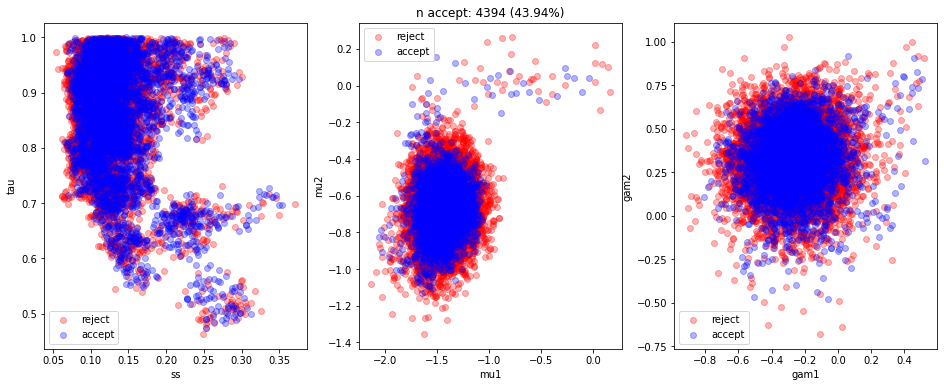

In [41]:
plot_ar(cands, plot_status=True, status=status)

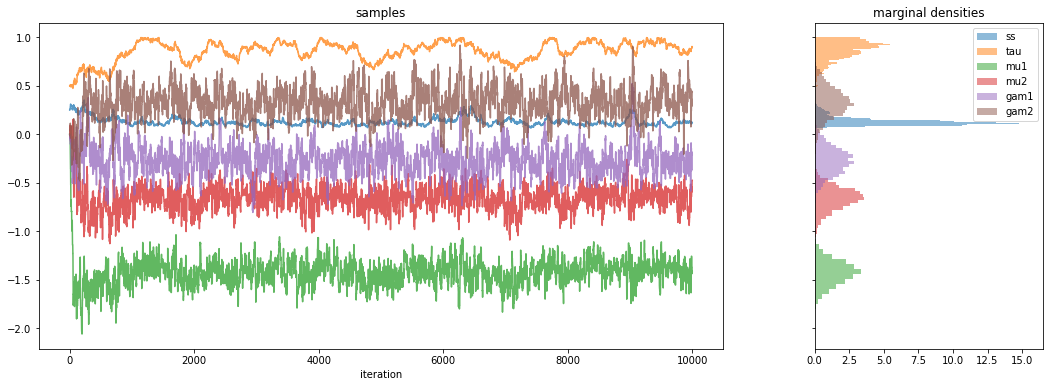

In [42]:
plot_marginals(xt)

## Gibs sampling

In [30]:
theta = [0.25, 0.5, np.array([0,0]), np.array([0,0])]

In [31]:
def val_gibbs_ss(block_theta, Y, groups):
    # unravel theta
    ss, tau, mu, gam = theta

    #get counts
    __, ns = np.unique(groups, return_counts=True)
    n = ns.sum()

    # get sumof squares
    mean_set = [mu, gam, (mu + gam)/2, tau*mu + (1-tau)*gam]
    means = []
    for n_i, mean_i in zip(ns, mean_set):
        for i in range(n_i):
            means += [mean_i]
    means = np.array(means)

    # define parameters and draw
    ss_scale = np.sum(np.square(Y - means)) / 2
    ss_shape = n / 2
    prop_ss = sps.invgamma.rvs(a=ss_shape, scale=ss_scale)
    
    return prop_ss

val_gibbs_ss(theta, Y, groups)

0.8100892703897796

In [32]:
def val_gibbs_mu(theta, Y, groups):
    # unravel theta
    ss, tau, __, gam = theta

    #get counts
    __, ns = np.unique(groups, return_counts=True)
    n = ns.sum()
    
    # calculate mean/var
    mu_denom = ns[0] + ns[2]/4 + ns[3]*tau**2
    mean_mu_num = (Y[groups == 1].sum(axis=0) + 0.5*Y[groups == 3].sum(axis=0) + tau*Y[groups == 4].sum(axis=0) + 
        (ns[2]/4 + ns[3]*tau*(1-tau))*gam)
    mean_mu = mean_mu_num / mu_denom
    var_mu = ss / mu_denom

    # generate sample
    prop_mu = sps.multivariate_normal.rvs(mean=mean_mu, cov=var_mu)
    return prop_mu

val_gibbs_mu(theta, Y, groups)

array([-1.52642339, -0.57352809])

In [33]:
def val_gibbs_gam(theta, Y, groups):
    # unravel theta
    ss, tau, mu, __ = theta

    #get counts
    __, ns = np.unique(groups, return_counts=True)
    n = ns.sum()
    
    # calculate mean/var
    gam_denom = ns[1] + ns[2]/4 + ns[3]*(1-tau)**2
    mean_gam_num = (Y[groups == 2].sum(axis=0) + 0.5*Y[groups == 3].sum(axis=0) + (1-tau)*Y[groups == 4].sum(axis=0) + 
        (ns[2]/4 + ns[3]*tau*(1-tau))*mu)
    mean_gam = mean_gam_num / gam_denom
    var_gam = ss / gam_denom

    # generate sample
    prop_gam = sps.multivariate_normal.rvs(mean=mean_gam, cov=var_gam)
    return prop_gam

val_gibbs_gam(theta, Y, groups)

array([-1.28797074, -0.61523571])

In [59]:
def val_gibbs_tau(theta, Y, groups, eps=0.00001):
    # unravel theta
    ss, __, mu, gam = theta

    #get counts
    __, ns = np.unique(groups, return_counts=True)
    n = ns.sum()

    # error handling in case mu == gam (divide by zero error)
    if (mu == gam).all():
        denom = eps
    else:
        denom = np.dot((mu - gam), (mu - gam))
    
    mean_tau = np.dot((mu - gam), (Y[groups == 4] - gam).sum(axis=0)) / denom
    var_tau = ss / (ns[3] * denom)
    std_tau = np.sqrt(var_tau)
    tau = sps.truncnorm.rvs(a=(0 - mean_tau) / var_tau, 
                            b=(1 - mean_tau) / var_tau, 
                            loc=mean_tau, scale=var_tau)
    return tau
val_gibbs_tau(theta, Y, groups)

0.21166393869913167

In [60]:
T = 10000
xt = []
continuous_scan = False
cond_dists = [val_gibbs_ss, val_gibbs_tau, val_gibbs_mu, val_gibbs_gam]

# Initialize then iterate
x0 = np.array((0.25, 0.5, np.array([0, 0]), np.array([0, 0])), dtype=object)
x = x0

for t in tqdm(range(T)):
    # sample iteratively from conditional distributions
    # determine scan
    if continuous_scan:
        update_idx = np.array(range(4))
    else:
        update_idx = np.random.choice(range(4), 4, replace=False)
    for j in update_idx:
        x[j] = cond_dists[j](x, Y, groups)
    
    # record in flattened state
    xt += [np.hstack(x)]

xt = np.array(xt)

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1475.10it/s]


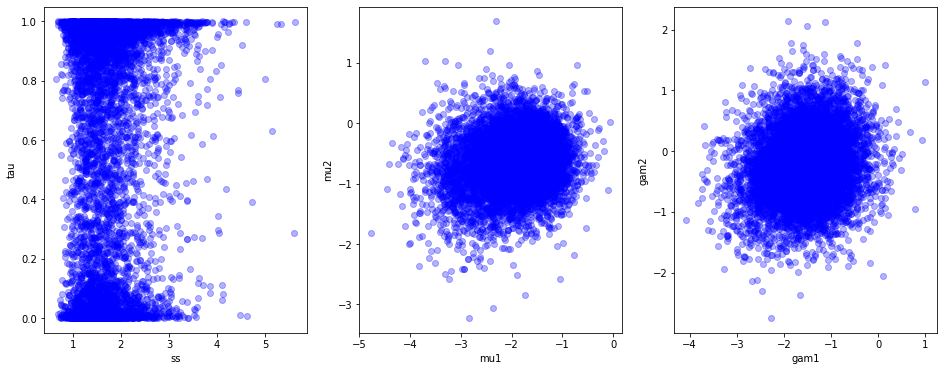

In [61]:
plot_ar(xt, plot_status=False)

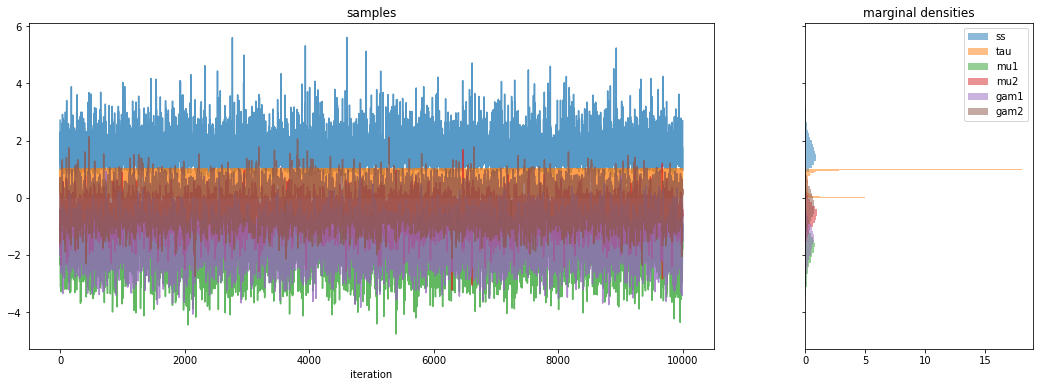

In [62]:
plot_marginals(xt)